# Setup

In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import logomaker

import Bio.Align
from pymoo.indicators.hv import HV
from sklearn.decomposition import PCA
from scipy.stats import entropy
from sklearn.manifold import SpectralEmbedding

In [13]:
sns.set(font_scale= 1., font= 'Arial')
sns.set_style('ticks')

In [14]:
bright_colors= sns.color_palette('bright')

cb_colors= np.array([
    [221, 221, 221],
    [46, 37, 133],
    [51, 117, 56],
    [93, 168, 153],
    [148, 203, 236],
    [220, 205, 125],
    [194, 106, 119],
    [159, 74, 150],
    [126, 41, 84]
])/255

In [15]:
blosum62= Bio.Align.substitution_matrices.load('BLOSUM62')
aligner= Bio.Align.PairwiseAligner()
aligner.substitution_matrix= blosum62

In [16]:
def hex_to_rgb(value: str) -> list:
    value = value.lstrip('#')
    lv = len(value)
    return list(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
    
def hex_interpolate(init, fin, scale: float) -> str:
    if isinstance(init, str):
        init_rgb= np.array(hex_to_rgb(init))
    else:
        init_rgb= 255*np.asarray(init)
    if isinstance(fin, str):
        fin_rgb= np.array(hex_to_rgb(fin))
    else:
        fin_rgb= 255*np.asarray(fin)
    
    color_rgb= (init_rgb + scale*(fin_rgb - init_rgb))/255.
    
    return tuple(color_rgb)

def des_identity(WT_seq, seqs):
    WT_arr= np.array(list(WT_seq))
    seqs_arr= np.array([list(seq) for seq in seqs])
    identities= np.sum(seqs_arr == WT_arr, axis= -1)/len(WT_arr)
    return identities

# Process benchmark data

Read in collated benchmark data

In [38]:
PapD_data= pd.read_parquet('data/benchmark_collated.gz.parquet')

Split data and compute summary statistics

In [42]:
n_generation= 50

des_resids= [1, 3, 4, 5, 6, 7, 8, 31, 91, 104, 105, 106, 107, 108, 109, 110, 112, 152, 154, 163, 164, 166, 170, 194, 200]

af2rank_HV_ref_pt= np.array([0., 0., 0.])
af2rank_hv_operator= HV(ref_point= af2rank_HV_ref_pt)

protein_mpnn_HV_ref_pt= np.array([4, 4, 4])
protein_mpnn_hv_operator= HV(ref_point= protein_mpnn_HV_ref_pt)

af2rank_metrics_list= [
    'neg_af2rank_composite_chain_AB_model_1_multimer_v3', 
    'neg_af2rank_composite_chain_CD_model_1_multimer_v3', 
    'neg_af2rank_composite_chain_EF_model_1_multimer_v3'
]
pmpnn_metrics_list= [
    'protein_mpnn_neg_log_prob_all_positions_chain_AB', 
    'protein_mpnn_neg_log_prob_all_positions_chain_CD', 
    'protein_mpnn_neg_log_prob_all_positions_chain_EF'
]

In [40]:
# WT data
wt_data= PapD_data[PapD_data['method'] == 'WT'].squeeze()

wt_dict= {
    'identity': 1.0,
    'esm': -wt_data['neg_esm1v_chain_A'],
    'hv_protein_mpnn': np.prod([(4 - wt_data[pmpnn_metric]) for pmpnn_metric in pmpnn_metrics_list]),
    'hv_af2rank': -np.prod([wt_data[af2rank_metric] for af2rank_metric in af2rank_metrics_list])
}

In [25]:
# GA mutation operator & mutation rate benchmark data
df_GA_dict= {}
for GA_idx in range(1, 7):
    df_list= []
    af2rank_hv_list= []
    protein_mpnn_hv_list= []
    ave_identity_list= []
    ave_esm_list= []
    for itr in range(n_generation):
        df= PapD_data.query(f'GA_idx == {GA_idx} & iteration == {itr}')

        af2rank_hv= af2rank_hv_operator(df[af2rank_metrics_list].values)
        protein_mpnn_hv= protein_mpnn_hv_operator(df[pmpnn_metrics_list].values)
        ave_identity= np.mean(df['identity'])

        ave_esm= -np.mean(df['neg_esm1v_chain_A'])
        ave_esm_list.append(ave_esm)

        df_list.append(df)
        af2rank_hv_list.append(af2rank_hv)
        protein_mpnn_hv_list.append(protein_mpnn_hv)
        ave_identity_list.append(ave_identity)

    df_GA_dict[GA_idx]= {
        'df': df_list, 
        'hv_af2rank': af2rank_hv_list, 
        'hv_protein_mpnn': protein_mpnn_hv_list, 
        'identity': ave_identity_list, 
        'esm': ave_esm_list
    }

In [26]:
# ProteinMPNN-AD multistate design data
df_AD_dict= {}

df= PapD_data.query('method == "AD" & temp == 0.3')

af2rank_hv= af2rank_hv_operator(df[af2rank_metrics_list].values)
protein_mpnn_hv= protein_mpnn_hv_operator(df[pmpnn_metrics_list].values)
ave_identity= np.mean(df['identity'])

ave_esm= -np.mean(df['neg_esm1v_chain_A'])

df_AD_dict= {
    'df': df, 
    'hv_af2rank': af2rank_hv, 
    'hv_protein_mpnn': protein_mpnn_hv, 
    'identity': ave_identity, 
    'esm': ave_esm
}

# Data visualization

GA mutation operator & mutation rate benchmark summary plot

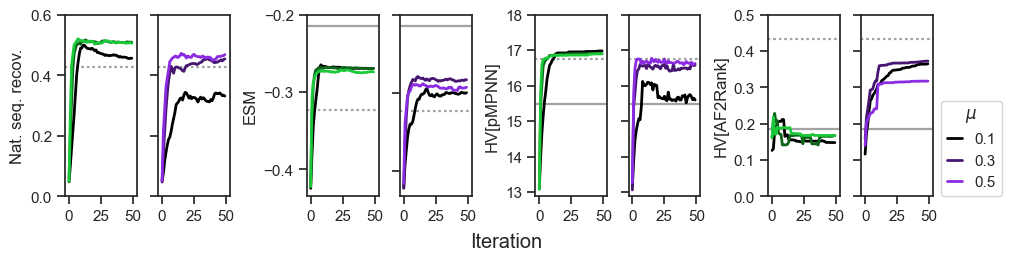

In [27]:
fig, axes= plt.subplots(1, 8, figsize= (10, 2.5), sharex= True, layout= 'constrained')

df_GA_1_dict_list= [df_GA_dict[idx] for idx in [1, 2, 3]]
df_GA_2_dict_list= [df_GA_dict[idx] for idx in [4, 5, 6]]
mu_list= [0.1, 0.3, 0.5]

color_idx= 0
for metric_idx, metric in enumerate(['identity', 'esm', 'hv_protein_mpnn', 'hv_af2rank']):
    for mu_idx, (mu, df1, df2) in enumerate(zip(mu_list, df_GA_1_dict_list, df_GA_2_dict_list)):
        for idx, data_dict in enumerate([df1, df2]):
            ax= axes[2*metric_idx + idx]

            ax.axhline(df_AD_dict[metric], color= bright_colors[-3], linestyle= 'dotted', zorder= 0)
            if metric_idx != 0:
                ax.axhline(wt_dict[metric], color= bright_colors[-3], linestyle= 'solid', zorder= 0)

            y_data= data_dict[metric]
            x_data= list(range(len(y_data)))
            sns.lineplot(
                x= x_data, y= y_data,
                linewidth= 2,
                color= hex_interpolate(
                    [0, 0, 0], 
                    bright_colors[2] if idx == 0 else bright_colors[4], 
                    mu_idx/(len(mu_list) - 1)
                ),
                label= mu,
                ax= ax
            )
            color_idx+= 1

            ax.set(
                xlim= [-3, 53],
                xticks= [0, 25, 50],
                #title= f'{settings["choose_pos_method"]},{settings["choose_AA_method"]}\n{settings["objective_type"]}\n{idx-6}-{idx}' if metric_idx == 0 else ''
            )
            if metric_idx == 0:
                ax.set(yticks= [0., 0.2, 0.4, 0.6])
            elif metric_idx == 1:
                ax.set(yticks= [-0.4, -0.3, -0.2])
            elif metric_idx == 2:
                ax.set(yticks= [13, 14, 15, 16, 17, 18])
            elif metric_idx == 3:
                ax.set(yticks= [0., 0.1, 0.2, 0.3, 0.4, 0.5])

            try:
                ax.get_legend().remove()
            except:
                pass

            if idx == 1:
                ax.set(yticklabels= [])

axes[0].set(
    ylabel= 'Nat. seq. recov.'
)
axes[2].set(
    ylabel= 'ESM'
)
axes[4].set(
    ylabel= 'HV[pMPNN]'
)
axes[6].set(
    ylabel= 'HV[AF2Rank]'
)

ax= axes[7]
legend_handles, _= ax.get_legend_handles_labels()
ax.legend(
    legend_handles, mu_list, title= r'$\mu$',
    bbox_to_anchor= (1, 0.57), loc= 'upper left',
    ncol= 1, columnspacing= 0.3, handlelength= 1
)

fig.align_labels()
fig.supxlabel('Iteration')

plt.show()

#fig.savefig('/home/lu/Dropbox/multistate_paper/fig_parts/PapD_GA_benchmark_stats.svg', bbox_inches='tight', dpi= 600)

Sequence anlaysis plot

In [29]:
L107_idx= des_resids.index(107)

In [30]:
pca_af2rank = PCA(n_components=2, random_state= 1)

ga_af2rank_df= df_GA_dict[5]['df'][-1][af2rank_metrics_list + ['candidate']].copy()
ga_af2rank_df['method']= 'GA[AF2Rank]'
ga_af2rank_df['107']= [des_seq[L107_idx] for des_seq in df_GA_dict[5]['df'][-1]['candidate']]

ga_pmpnn_df= df_GA_dict[2]['df'][-1][af2rank_metrics_list + ['candidate']].copy()
ga_pmpnn_df['method']= 'GA[pMPNN]'
ga_pmpnn_df['107']= [des_seq[L107_idx] for des_seq in df_GA_dict[2]['df'][-1]['candidate']]

ad_df= df_AD_dict['df'][af2rank_metrics_list + ['candidate']].copy()
ad_df['method']= 'AD'
ad_df['107']= [des_seq[L107_idx] for des_seq in df_AD_dict['df']['candidate']]

wt_df= wt_data.to_frame().T[af2rank_metrics_list + ['candidate']]
wt_df['method']= 'WT'
wt_df['107']= ['L']

af2rank_df= pd.concat(
    [ad_df, ga_pmpnn_df, ga_af2rank_df, wt_df],
).reset_index(drop= True)

af2rank_pca_df= pd.DataFrame(
    pca_af2rank.fit_transform(
        af2rank_df[af2rank_metrics_list]
    ),
    columns= ['PC1', 'PC2']
)

af2rank_pca_df= pd.merge(
    left= af2rank_df,
    right= af2rank_pca_df,
    left_index= True,
    right_index= True,
    validate= '1:1'
)

In [31]:
pca_pmpnn = PCA(n_components=2, random_state= 1)

ga_af2rank_df= df_GA_dict[5]['df'][-1][pmpnn_metrics_list + ['candidate']].copy()
ga_af2rank_df['method']= 'GA[AF2Rank]'
ga_af2rank_df['107']= [des_seq[L107_idx] for des_seq in df_GA_dict[5]['df'][-1]['candidate']]

ga_pmpnn_df= df_GA_dict[2]['df'][-1][pmpnn_metrics_list + ['candidate']].copy()
ga_pmpnn_df['method']= 'GA[pMPNN]'
ga_pmpnn_df['107']= [des_seq[L107_idx] for des_seq in df_GA_dict[2]['df'][-1]['candidate']]

ad_df= df_AD_dict['df'][pmpnn_metrics_list + ['candidate']].copy()
ad_df['method']= 'AD'
ad_df['107']= [des_seq[L107_idx] for des_seq in df_AD_dict['df']['candidate']]

wt_df= wt_data.to_frame().T[pmpnn_metrics_list + ['candidate']]
wt_df['method']= 'WT'
wt_df['107']= ['L']

pmpnn_df= pd.concat(
    [ad_df, ga_pmpnn_df, ga_af2rank_df, wt_df],
).reset_index(drop= True)

pmpnn_pca_df= pd.DataFrame(
    pca_pmpnn.fit_transform(
        pmpnn_df[pmpnn_metrics_list]
    ),
    columns= ['PC1', 'PC2']
)
pmpnn_pca_df= pd.merge(
    left= pmpnn_df,
    right= pmpnn_pca_df,
    left_index= True,
    right_index= True,
    validate= '1:1'
)

In [32]:
msa_ga_pmpnn= logomaker.alignment_to_matrix(df_GA_dict[2]['df'][-1]['candidate'], to_type= 'counts')
msa_ga_af2rank= logomaker.alignment_to_matrix(df_GA_dict[5]['df'][-1]['candidate'], to_type= 'counts')
msa_AD= logomaker.alignment_to_matrix(df_AD_dict['df']['candidate'], to_type= 'counts')
all_resids= des_resids
all_resids_idx= pd.Index(all_resids, name= 'pos')
msa_ga_pmpnn.index= all_resids_idx
msa_ga_af2rank.index= all_resids_idx
msa_AD.index= all_resids_idx

entropy_GA1= []
for idx, pos in msa_ga_pmpnn.iterrows():
    entropy_GA1.append(entropy(list(pos)))

entropy_GA2= []
for idx, pos in msa_ga_af2rank.iterrows():
    entropy_GA2.append(entropy(list(pos)))

entropy_AD= []
for idx, pos in msa_AD.iterrows():
    entropy_AD.append(entropy(list(pos)))

In [33]:
blosum_matrix= []
for candidate_1, method_1 in zip(af2rank_pca_df['candidate'], af2rank_pca_df['method']):
    blosum_dists= []
    for candidate_2, method_2 in zip(af2rank_pca_df['candidate'], af2rank_pca_df['method']):
        blosum_dist= aligner.align(str(candidate_1), str(candidate_2)).score/len(candidate_1)
        blosum_dists.append(blosum_dist)
    blosum_matrix.append(blosum_dists)
blosum_matrix= np.asarray(blosum_matrix)

embedding = SpectralEmbedding(n_components=2, affinity= 'precomputed')
blosum_matrix_transformed = embedding.fit_transform(blosum_matrix)

embedding_df= pd.DataFrame({'seq_embed_1': blosum_matrix_transformed[:, 0], 'seq_embed_2': blosum_matrix_transformed[:, 1], 'method': af2rank_pca_df['method']})

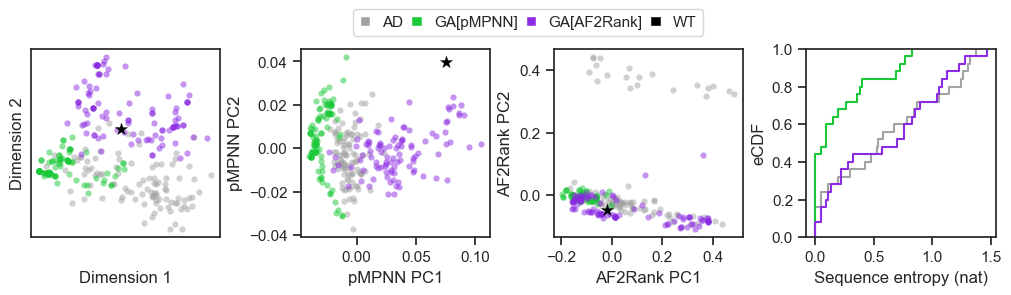

In [34]:
alpha= 0.5
s= 20

fig, axes= plt.subplots(1, 4, figsize= (10, 2.5), layout= 'constrained')

x_data= 'PC1'
y_data= 'PC2'
pmpnn_pc_xlim= (-0.05, 0.12)
pmpnn_pc_ylim= (-0.04, 0.045)
ax= axes[1]
sns.scatterplot(data= pmpnn_pca_df[pmpnn_pca_df['method'] == 'AD'], x= x_data, y= y_data, label= 'AD', ax= ax, color= bright_colors[-3], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= pmpnn_pca_df[pmpnn_pca_df['method'] == 'GA[pMPNN]'], x= x_data, y= y_data, label= 'GA_31', ax= ax, color= bright_colors[2], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= pmpnn_pca_df[pmpnn_pca_df['method'] == 'GA[AF2Rank]'], x= x_data, y= y_data, label= 'GA_38', ax= ax, color= bright_colors[4], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= pmpnn_pca_df[pmpnn_pca_df['method'] == 'WT'], x= x_data, y= y_data, label= 'WT', marker= "*", ax= ax, color= 'black', alpha= 1., s= 5*s, linewidth= 0)
ax.set(
    xlabel= 'pMPNN PC1', ylabel= 'pMPNN PC2',
    #xlim= pmpnn_pc_xlim, ylim= pmpnn_pc_ylim
)
ax.get_legend().remove()
#ax.set_aspect('equal')

x_data= 'PC1'
y_data= 'PC2'
af2rank_pc_xlim= (-0.25, 0.55)
af2rank_pc_ylim= (-0.15, 0.5)
ax= axes[2]
sns.scatterplot(data= af2rank_pca_df[af2rank_pca_df['method'] == 'AD'], x= x_data, y= y_data, label= 'AD', ax= ax, color= bright_colors[-3], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= af2rank_pca_df[af2rank_pca_df['method'] == 'GA[pMPNN]'], x= x_data, y= y_data, label= 'GA_31', ax= ax, color= bright_colors[2], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= af2rank_pca_df[af2rank_pca_df['method'] == 'GA[AF2Rank]'], x= x_data, y= y_data, label= 'GA_38', ax= ax, color= bright_colors[4], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= af2rank_pca_df[af2rank_pca_df['method'] == 'WT'], x= x_data, y= y_data, label= 'WT', marker= "*", ax= ax, color= 'black', alpha= 1., s= 5*s, linewidth= 0)
ax.set(
    xlabel= 'AF2Rank PC1', ylabel= 'AF2Rank PC2',
    #xlim= af2rank_pc_xlim, ylim= af2rank_pc_ylim
)
ax.get_legend().remove()
#ax.set_aspect('equal')

ax= axes[0]
x_data= 'seq_embed_1'
y_data= 'seq_embed_2'
sns.scatterplot(data= embedding_df[embedding_df['method'] == 'AD'], x= x_data, y= y_data, label= 'AD', ax= ax, color= bright_colors[-3], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= embedding_df[embedding_df['method'] == f'GA[pMPNN]'], x= x_data, y= y_data, label= 'GA_31', ax= ax, color= bright_colors[2], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= embedding_df[embedding_df['method'] == f'GA[AF2Rank]'], x= x_data, y= y_data, label= 'GA_38', ax= ax, color= bright_colors[4], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= embedding_df[embedding_df['method'] == 'WT'], x= x_data, y= y_data, label= 'WT', marker= "*", ax= ax, color= 'black', alpha= 1., s= 5*s, linewidth= 0)

ax.set(
    xlabel= 'Dimension 1', ylabel= 'Dimension 2',
    xticks= [], xticklabels= [], yticks= [], yticklabels= []
)
ax.get_legend().remove()
#ax.set_aspect('equal')

ax= axes[3]
sns.ecdfplot(x= entropy_AD, ax= ax, color= bright_colors[-3])
sns.ecdfplot(x= entropy_GA1, ax= ax, color= bright_colors[2])
sns.ecdfplot(x= entropy_GA2, ax= ax, color= bright_colors[4])

ax.set(xlabel= 'Sequence entropy (nat)', ylabel= 'eCDF')

#plt.legend(loc= 'lower right')

fig.align_labels()

handles= [
    mpatches.Patch(facecolor= bright_colors[-3], label= 'AD'),
    mpatches.Patch(facecolor= bright_colors[2], label= 'GA[pMPNN]'),
    mpatches.Patch(facecolor= bright_colors[4], label= 'GA[AF2Rank]'),
    mpatches.Patch(facecolor= (0, 0, 0), label= 'WT')
]

fig.legend(
    handles= handles,
    bbox_to_anchor= (0.34, 1.15), loc= 'upper left',
    ncol= 6, columnspacing= 0.5, handlelength= 0.7
)

plt.show()

#fig.savefig('/home/lu/Dropbox/multistate_paper/fig_parts/PapD_benchmark_scatter.svg', bbox_inches='tight', dpi= 600)

Sequence logo plots

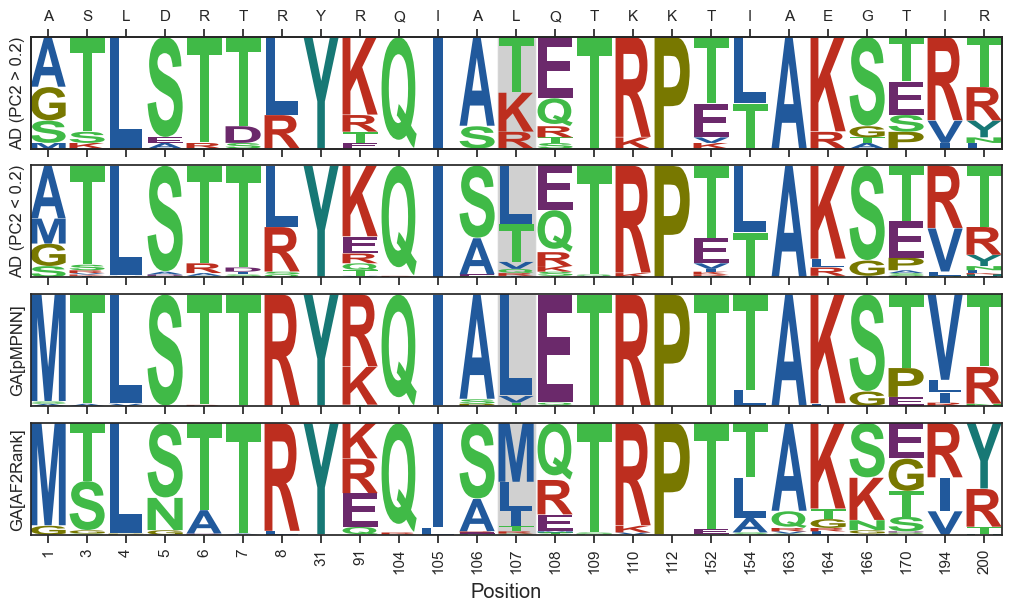

In [45]:
fig, axes= plt.subplots(4, 1, figsize= (10, 4*1.5), layout= 'constrained', sharex= True)

pc2_above= af2rank_pca_df[(af2rank_pca_df['method'] == 'AD') & (af2rank_pca_df['PC2'] > 0.2)]['candidate']
msa= logomaker.alignment_to_matrix(pc2_above, to_type= 'counts')
logo_pc2_above= logomaker.Logo(msa, ax= axes[0], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)
axes[0].set(ylabel= 'AD (PC2 > 0.2)', yticks= [])

ax2= axes[0].twiny()
ax2.set_xlim(axes[0].get_xlim())
ax2.set_xticks(np.array(range(len(wt_data['candidate']))))
ax2.set_xticklabels(wt_data['candidate'])

pc2_below= af2rank_pca_df[(af2rank_pca_df['method'] == 'AD') & (af2rank_pca_df['PC2'] < 0.2)]['candidate']
msa= logomaker.alignment_to_matrix(pc2_below, to_type= 'counts')
logo_pc2_below= logomaker.Logo(msa, ax= axes[1], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)
axes[1].set(ylabel= 'AD (PC2 < 0.2)', yticks= [])

msa= logomaker.alignment_to_matrix(af2rank_pca_df[af2rank_pca_df['method'] == 'GA[pMPNN]']['candidate'], to_type= 'counts')
logo_pmpnn= logomaker.Logo(msa, ax= axes[2], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)
axes[2].set(ylabel= 'GA[pMPNN]', yticks= [])

msa= logomaker.alignment_to_matrix(af2rank_pca_df[af2rank_pca_df['method'] == 'GA[AF2Rank]']['candidate'], to_type= 'counts')
logo_af2rank= logomaker.Logo(msa, ax= axes[3], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)
axes[3].set(ylabel= 'GA[AF2Rank]', yticks= [])

axes[3].set(xticks= list(range(len(des_resids))))
axes[3].set_xticklabels(des_resids, rotation= 90)

fig.supxlabel('Position')

highlight_color= sns.color_palette('bright')[-3]
highlight_alpha= 0.5
highlight_positions= [des_resids.index(107)]
for idx in highlight_positions:
    logo_pc2_above.highlight_position(p= idx, color= highlight_color, alpha= highlight_alpha)
    logo_pc2_below.highlight_position(p= idx, color= highlight_color, alpha= highlight_alpha)
    logo_pmpnn.highlight_position(p= idx, color= highlight_color, alpha= highlight_alpha)
    logo_af2rank.highlight_position(p= idx, color= highlight_color, alpha= highlight_alpha)

plt.show()

#fig.savefig('/home/lu/Dropbox/multistate_paper/SI_fig_parts/PapD_seq_logo_L107.svg', bbox_inches='tight', dpi= 600)